# Chapter08 이미지를 위한 인공 신경망

### 08-1 합성곱 신경망의 구성 요소

**합성곱** (convolution) :

입력 데이터 전체에 가중치를 적용하는 것이 아닌 일부에 가중치를 곱함

합성곱 신경망 ( CNN ) 에서는 뉴런을 '*필터 or 커널* ' 이라고 부름

- 커널 : 입력에 곱하는 가중치를 표현

- 필터 : 뉴런 개수를 표현 (도장)

- 특성 맵 : 합성곱 계산을 통해 얻은 출력

---

합성곱 층에서도 여러 개의 필터를 사용한다. --> 특성 맵이 3차원이 된다.

각 필터마다 가중치가 다르며, 편향이 존재한다. ( 편향은 모두 같음??????? )

In [1]:
# 케라스 합성곱 층
# (왼쪽에서 오른쪽으로, 위에서 아래로) 이동하는 합성곱 : Conv2D 클래스
from tensorflow import keras
keras.layers.Conv2D(10, kernel_size=(3,3), activation='relu')  # 필터개수, 커널크기, 활성화함수 지정

# 활성화 함수는 ReLU함수가 많이 쓰인다

패딩과 스트라이트

- **패딩** : 입력 배열의 주위를 가상의 원소로 채우는 것 ( 출력의 크기를 늘리기 위해 쓰임 )

 - 세임 패딩 : 입력과 특성 맵의 크기를 동일하게 만들기 위해 입력 주위에 0으로 패딩하는 것 ( 입력크기 == 특성 맵 크기 )

 - 밸리드 패딩 : 패딩 없이 순수한 입력 배열에서만 합성곱을 하여 특성 맵을 만드는 경우

적절한 패딩은 이미지의 주변(테두리)에 있는 정보를 잃어버리지 않도록 도와준다.

In [2]:
keras.layers.Conv2D(10, kernel_size=(3,3), activation='relu', padding='same')   # padding의 기본값은 valid

- **스트라이드** : 이동하는 크기 ( 기본값: 1 ) , 즉 기본값으로는 한칸씩 이동함

In [3]:
keras.layers.Conv2D(10, kernel_size=(3,3), activation='relu', padding='same', strides=1)
# strides=(m,n) 으로 지정하면 오른쪽으로 이동할 때는 m만큼, 아래로 이동할 때는 n만큼 이동 (잘 안씀)

- **풀링** : 특성 맵의 가로세로 크기를 줄이는 역할을 수행

 특성 맵에 커널 없는 필터를 적용하는 것과 비슷하다.

 - 최대 풀링 : 특성 맵에서 가장 큰 값을 고름

 - 평균 풀링 : 특성 맵에서 평균값을 계산함

풀링에서는 합성곱과 달리 겹치는 부분 없이 이동을 한다. --> 풀링 크기와 스트라이드 크기가 같다.

ex) 풀링의 크기가 (2,2)라면 2칸씩 이동, (3,3)라면 3칸씩 이동

대부분 평균풀링보다 최대풀링을 더 많이 사용한다.

In [4]:
# 케라스에서의 풀링
keras.layers.MaxPooling2D(2)      # 최대 풀링
keras.layers.AveragePooling2D(2)  # 평균 풀링
# 풀링크기를 지정해주어야 함

In [5]:
keras.layers.MaxPooling2D(2, strides=2, padding='valid')   # strides의 기본값은 자동으로 풀링의 크기이므로 지정할 필요X,
#                                                            padding도 기본으로 valid이므로 지정할 필요X

풀링을 사용하는 이유 : 

스트라이드를 크게 하여 특성 맵을 줄이는 것보다 풀링으로 줄이는 것이 경험적으로 더 나은 성능을 내기 때문

---

컬러 이미지를 사용한 합성곱

컬러 이미지는 RGB로 구성되어 있기 때문에, 3차원 배열로 표시한다,

--> 필터의 커널 크기가 (3,3)이 아니라 (3,3,3)이 되어야 한다.

흑백 이미지일 경우에도 깊이차원이 1인 3차원 배열로 변환하여 전달한다. (28,28) --> (28,28,1) 이렇게

---

- 합성곱 신경망은 너비와 높이는 점점 줄어들고 깊이는 점점 깊어지는 것이 특징이다.

- 마지막에 출력층 전에 특성 맵을 모두 펼쳐서 (1차원으로 만들어) 밀집층의 입력으로 사용한다.

### 08-2 합성곱 신경망을 사용한 이미지 분류

In [6]:
# 패션 MNIST 데이터 불러오기
from tensorflow import keras
from sklearn.model_selection import train_test_split
(train_input, train_target), (test_input, test_target) = keras.datasets.fashion_mnist.load_data()
train_scaled = train_input.reshape(-1, 28, 28, 1) / 255.0   # Conv2D층을 사용하기 위해 채널 차원 추가
train_scaled, val_scaled, train_target, val_target = train_test_split(
    train_scaled, train_target, test_size=0.2, random_state=42)

4423680/4422102 [==============================] - 0s 0us/step


In [7]:
print(train_scaled.shape, train_target.shape)

(48000, 28, 28, 1) (48000,)


In [8]:
model = keras.Sequential()

# 첫 번째 합성곱 층 추가
model.add(keras.layers.Conv2D(32, kernel_size=3, activation='relu',
                              padding='same', input_shape=(28,28,1)))

# 이 합성곱 층은 32개의 필터를 사용하며, 커널의 크기는 (3,3), ReLU함수와 세임패딩을 사용한다

In [9]:
model.add(keras.layers.MaxPooling2D(2))  # 풀링 층 추가, 풀링크기: (2,2)

# (2,2)의 풀링을 적용했으므로, 특성 맵 크기는 절반으로 줄어든다

In [10]:
# 두 번째 합성곱-풀링 층 추가
model.add(keras.layers.Conv2D(64, kernel_size=3, activation='relu', 
                              padding='same'))  # 필터개수 64개로 늘림
model.add(keras.layers.MaxPooling2D(2))

In [11]:
model.add(keras.layers.Flatten())  # 특성 맵을 1차원으로 펼침
model.add(keras.layers.Dense(100, activation='relu'))   # 은닉층 추가
model.add(keras.layers.Dropout(0.4))                    # 드롭아웃 적용
model.add(keras.layers.Dense(10, activation='softmax')) # 최종 출력층

In [12]:
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_3 (Conv2D)            (None, 28, 28, 32)        320       
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 14, 14, 32)        0         
_________________________________________________________________
conv2d_4 (Conv2D)            (None, 14, 14, 64)        18496     
_________________________________________________________________
max_pooling2d_3 (MaxPooling2 (None, 7, 7, 64)          0         
_________________________________________________________________
flatten (Flatten)            (None, 3136)              0         
_________________________________________________________________
dense (Dense)                (None, 100)               313700    
_________________________________________________________________
dropout (Dropout)            (None, 100)               0

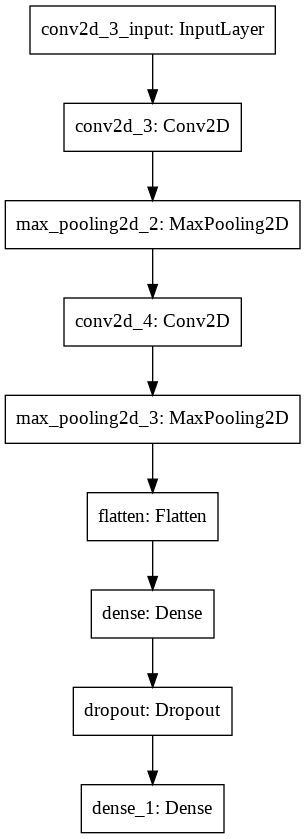

In [13]:
keras.utils.plot_model(model)   # 층의 구성을 그림으로 표현해주는 함수

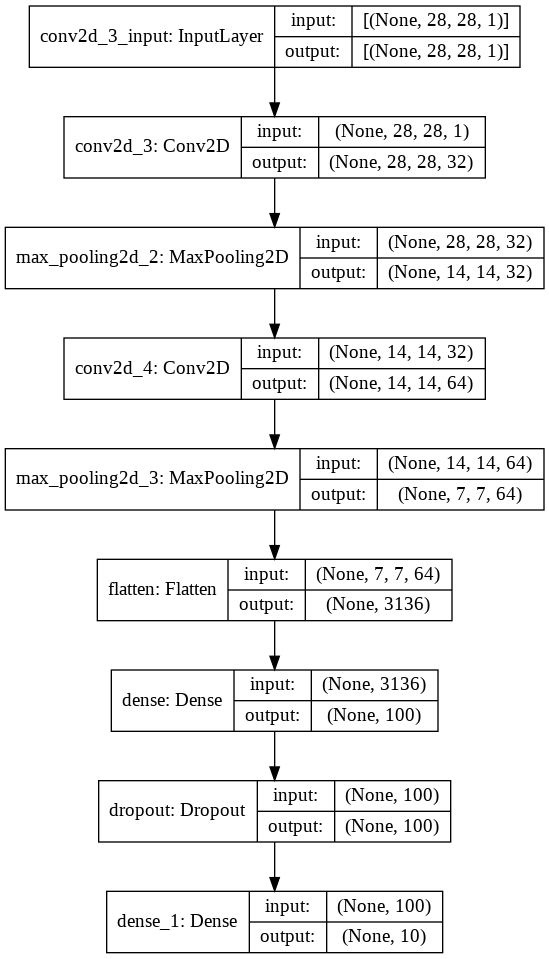

In [14]:
keras.utils.plot_model(model, show_shapes=True,                 # show_shapes=True: 입력과 출력의 크기를 표시해줌
                       to_file='cnn-architecture.png', dpi=96)  # to_file: 출력한 이미지를 파일로 저장, dpi: 해상도 지정

모델 컴파일과 훈련

In [15]:
model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics='accuracy')
checkpoint_cb = keras.callbacks.ModelCheckpoint('best-cnn-model.h5')          # ModelCheckpoint 콜백
early_stopping_cb = keras.callbacks.EarlyStopping(patience=2, restore_best_weights=True)  # 조기종료
history = model.fit(train_scaled, train_target, epochs=20,      # 그래프를 그리기 위해 history 에 fit 반환값 담기
                    validation_data=(val_scaled, val_target),
                    callbacks=[checkpoint_cb, early_stopping_cb])

Epoch 1/20
1500/1500 [==============================] - 65s 43ms/step - loss: 0.5074 - accuracy: 0.8195 - val_loss: 0.3319 - val_accuracy: 0.8805
Epoch 2/20
1500/1500 [==============================] - 63s 42ms/step - loss: 0.3366 - accuracy: 0.8789 - val_loss: 0.2839 - val_accuracy: 0.8963
Epoch 3/20
1500/1500 [==============================] - 63s 42ms/step - loss: 0.2881 - accuracy: 0.8946 - val_loss: 0.2618 - val_accuracy: 0.9022
Epoch 4/20
1500/1500 [==============================] - 63s 42ms/step - loss: 0.2634 - accuracy: 0.9038 - val_loss: 0.2435 - val_accuracy: 0.9070
Epoch 5/20
1500/1500 [==============================] - 63s 42ms/step - loss: 0.2380 - accuracy: 0.9128 - val_loss: 0.2400 - val_accuracy: 0.9094
Epoch 6/20
1500/1500 [==============================] - 63s 42ms/step - loss: 0.2193 - accuracy: 0.9198 - val_loss: 0.2436 - val_accuracy: 0.9088
Epoch 7/20
1500/1500 [==============================] - 64s 42ms/step - loss: 0.2022 - accuracy: 0.9254 - val_loss: 0.2384 -

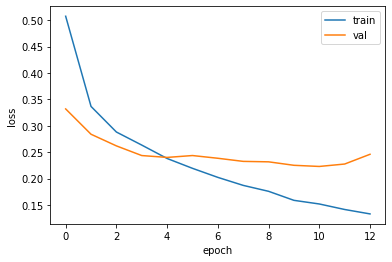

In [16]:
import matplotlib.pyplot as plt
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.xlabel('epoch')
plt.ylabel('loss')
plt.legend(['train', 'val'])
plt.show()

In [17]:
model.evaluate(val_scaled, val_target)

# 최적의 에포크의 [val_loss, val_accuracy]와 동일한 값임
# --> EarlyStopping콜백이 model 객체를 최상의 모델 파라미터로 잘 복원함

375/375 [==============================] - 5s 12ms/step - loss: 0.2229 - accuracy: 0.9242


[0.2228883057832718, 0.9241666793823242]

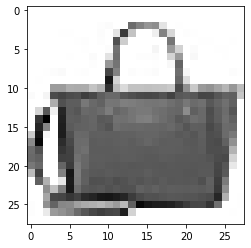

In [18]:
plt.imshow(val_scaled[0].reshape(28,28), cmap='gray_r')
plt.show()

In [19]:
preds = model.predict(val_scaled[0:1])   # predict(): 10개의 클래스에 대한 예측확률 반환
print(preds)

[[7.9725334e-26 5.3371484e-35 2.3378870e-29 2.8009370e-28 2.9803683e-26
  3.6255708e-26 1.2888252e-22 6.1941424e-31 1.0000000e+00 3.6065978e-29]]


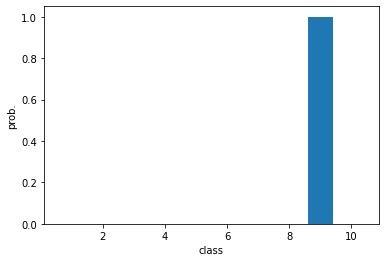

In [20]:
plt.bar(range(1,11), preds[0])
plt.xlabel('class')
plt.ylabel('prob.')
plt.show()

In [21]:
import numpy as np

classes = ['티셔츠','바지','스웨터','드레스','코드','샌달','셔츠','스니커즈','가방','앵클 부츠']
print(classes[np.argmax(preds)])   # 가방으로 예측!

가방


In [22]:
# 테스트 세트으로 측정
test_scaled = test_input.reshape(-1,28,28,1) / 255.0

model.evaluate(test_scaled, test_target)

# 테스트 세트는 항상 모델을 출시하기 직전 딱 한 번만 사용해야 한다!

313/313 [==============================] - 4s 13ms/step - loss: 0.2507 - accuracy: 0.9190


[0.25068721175193787, 0.9190000295639038]

### 08-3 합성곱 신경망의 시각화

가중치 시각화

In [23]:
# 앞에서 훈련했던 합성곱 신경망의 체크포인트 파일 사용
from tensorflow import keras
model = keras.models.load_model('best-cnn-model.h5')

In [24]:
model.layers  # 케라스 모델에 추가한 층이 저장되어 있음

In [25]:
conv = model.layers[0]
print(conv.weights[0].shape, conv.weights[1].shape)

# weights: 층의 가중치와 절편이 저장되어 있다

(3, 3, 1, 32) (32,)


In [26]:
conv_weights = conv.weights[0].numpy()
print(conv_weights.mean(), conv_weights.std())  # 넘파이 mean(), std()로 가중치 배열의 평균과 표준편차 계산

-0.010492599 0.2531201


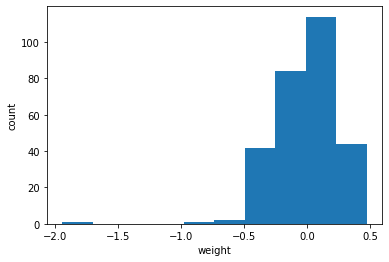

In [27]:
import matplotlib.pyplot as plt
plt.hist(conv_weights.reshape(-1,1))   # hist()에는 1차원 배열로 전달해야함
plt.xlabel('weight')
plt.ylabel('count')
plt.show()

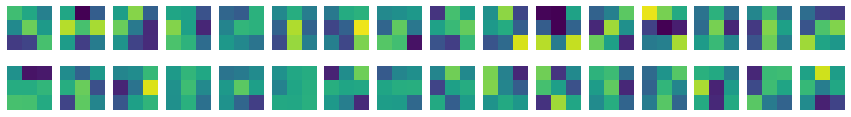

In [28]:
# 32개의 커널 16개씩 두 줄에 출력하기
fig, axs = plt.subplots(2, 16, figsize=(15,2))
for i in range(2):
    for j in range(16):
        axs[i,j].imshow(conv_weights[:,:,0,i*16 + j], vmin=-0.5, vmax=0.5)
        axs[i,j].axis('off')
plt.show()

# 밝은 부분의 값의 픽셀값이 더 높다

이 가중치 값이 무작위로 나열된 것이 아닌 어떤 패턴을 볼 수 있다.



In [29]:
# 훈련하지 않은 빈 합성곱 층
no_training_model = keras.Sequential()
no_training_model.add(keras.layers.Conv2D(32, kernel_size=3, activation='relu',
                                          padding='same', input_shape=(28,28,1)))

In [30]:
no_training_conv = no_training_model.layers[0]
print(no_training_conv.weights[0].shape)

(3, 3, 1, 32)


In [31]:
no_training_weights = no_training_conv.weights[0].numpy()
print(no_training_weights.mean(), no_training_weights.std())

-0.0063366685 0.080909565


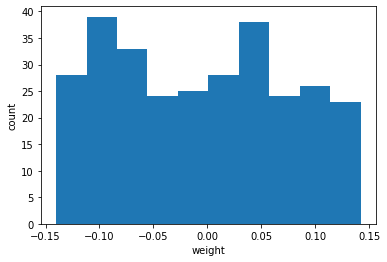

In [32]:
plt.hist(no_training_weights.reshape(-1,1))
plt.xlabel('weight')
plt.ylabel('count')
plt.show()

# 텐서플로가 신경망 가중치를 처음 초기화할 때 균등 분포에서 랜덤하게 값을 선택하기 때문에 
# 훈련된 것보다 표준편차가 매우 작다

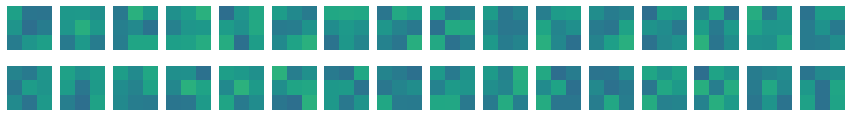

In [33]:
fig, axs = plt.subplots(2, 16, figsize=(15,2))
for i in range(2):
    for j in range(16):
        axs[i, j].imshow(no_training_weights[:,:,0,i*16 + j], vmin=-0.5, vmax=0.5)
        axs[i, j].axis('off')
plt.show()

# 훈련을 안해서 전체적으로 가중치가 밋밋하게 초기화되었다
# 이전의 출력을 보면 CNN이 데이터의 유용한 패턴을 학습했다는 것을 알 수 있다!

함수형 API

    dense1 = keras.layers.Dense(100, activation='sigmoid')
    dense2 = keras.layers.Dense(10, activation='softmax')

이 객체를 Sequential 클래스 객체의 add( ) 메서드에 전달할  수 있다.

    hidden = dense1(inputs)

    outputs = dense2(hidden)
하지만 이렇게 함수처럼 호출할 수 있다.

--> 함수형 API

    model = keras.Model(inputs, outputs)
그 다음 inputs와 outputs을 Model 클래스로 연결해준다.

Model 클래스를 우리가 수동으로 만들어서 호출해야 한다.

In [34]:
inputs = keras.Input(shape=(784,))

In [35]:
print(model.input)

KerasTensor(type_spec=TensorSpec(shape=(None, 28, 28, 1), dtype=tf.float32, name='conv2d_3_input'), name='conv2d_3_input', description="created by layer 'conv2d_3_input'")


In [36]:
# model.input과 model.layers[0].output을 연결하는 새로운 모델 생성
conv_acti = keras.Model(model.input, model.layers[0].output)

특성 맵 시각화

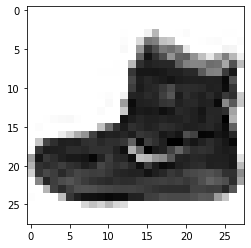

In [37]:
# 훈련세트에 있는 첫 번째 샘플
(train_input, train_target), (test_input, test_target) = keras.datasets.fashion_mnist.load_data()
plt.imshow(train_input[0], cmap='gray_r')
plt.show()

In [38]:
inputs = train_input[0:1].reshape(-1, 28, 28, 1) / 255.0
feature_maps = conv_acti.predict(inputs)

In [39]:
print(feature_maps.shape)

(1, 28, 28, 32)


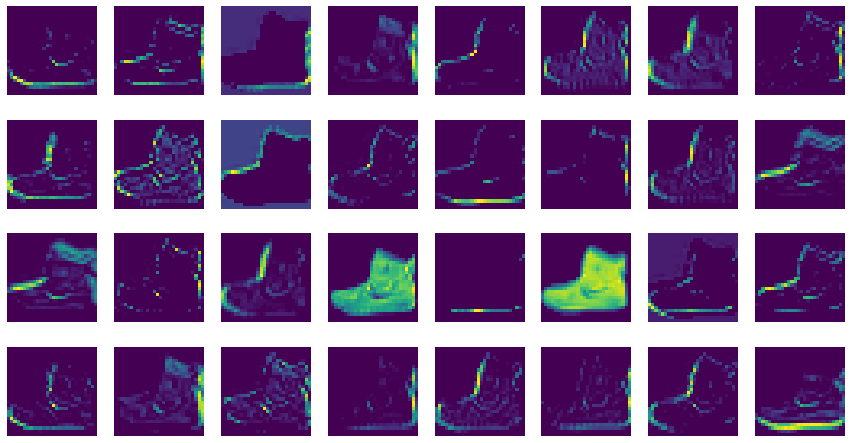

In [40]:
# 첫 번째 합성곱 층이 만든 특성 맵 그리기
fig, axs = plt.subplots(4, 8, figsize=(15,8))
for i in range(4):
    for j in range(8):
        axs[i, j].imshow(feature_maps[0,:,:,i*8 + j])
        axs[i, j].axis('off')
plt.show()

# 32개의 필터로 인해 입력 이미지에서 강하게 활성화된 부분을 보여준다!

In [41]:
# 두 번째 합성곱 층이 만든 특성 맵 확인
conv2_acti = keras.Model(model.input, model.layers[2].output)

In [42]:
inputs = train_input[0:1].reshape(-1, 28, 28, 1) / 255.0
feature_maps = conv2_acti.predict(inputs)

In [43]:
print(feature_maps.shape)

# 첫 번째 풀링 층에서 가로세로 크기가 절반 줄고,
# 두 번째 합성곱 층의 필터 개수가 64개이므로 (14,14,64)가 된다.

(1, 14, 14, 64)


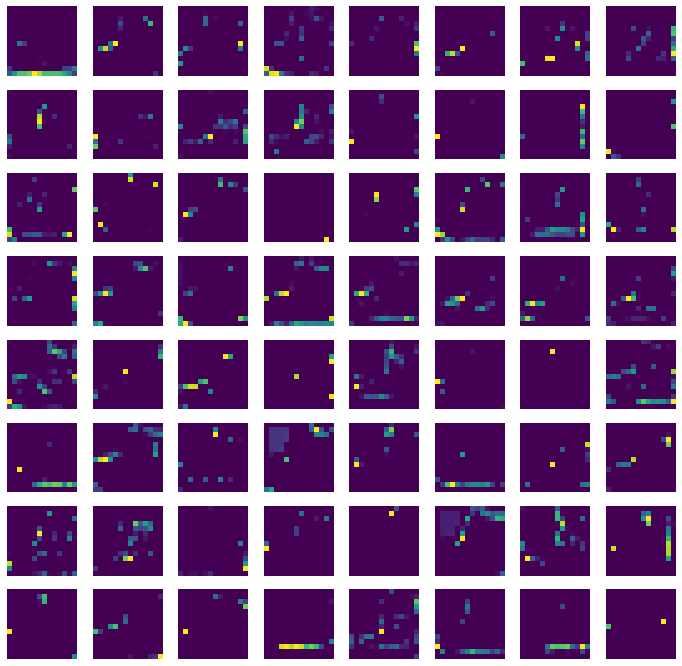

In [44]:
# 두 번째 합성곱 층이 만든 특성 맵 그리기
fig, axs = plt.subplots(8, 8, figsize=(12,12))
for i in range(8):
    for j in range(8):
        axs[i, j].imshow(feature_maps[0,:,:,i*8 + j])
        axs[i, j].axis('off')
plt.show()

# 첫 번째 합성곱 층보다 직관적으로 이해하기 어렵다
# --> 앞부분에서 감지한 시각적인 정보를 바탕으로 추상적인 정보를 학습한다!

입력에 가까운 합성곱 층은 이미지에서 시각적인 정보나 패턴을 감지하도록 훈련된다.

이어지는 합성곱 층은 이런 시각적인 정보를 활용해 조금 더 고차원적인 개념을 학습한다.